In [38]:
# Source: https://github.com/alan-turing-institute/sktime/blob/main/examples/01_forecasting.ipynb
# Source: https://www.kaggle.com/nageshsingh/stock-market-forecasting-arima

from warnings import simplefilter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
import mplfinance as fplt

from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster,
    ReducedForecaster,
    TransformedTargetForecaster,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import sMAPE, smape_loss
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series

from pylab import rcParams
rcParams['figure.figsize'] = 10,6

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose, STL

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

from datetime import timedelta


# Analyzing Apple Stock

1. Load Apple Stock data and drop unneeded columns -> We will focus on the closing price as the label to predict
2. Visualize the closing price of the stock over the entire data set.
3. Ensure there are no missing values in the series. If so, fill them appropriately.
3. Is the stock stationary?
    * To do this, we can do a Augment Dickey -Fuller Test that determines if there is a unit root in the series
    To read more: https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test
4. Separate out seasonality and trend to observe changes in stock price

# Features

We will engineer our own features based on the available data. We will use a variety of features however most will be
based around well known technical indicators such as moving average, exponential moving averages, momentum, Bollinger
Bands, Price volume Trend etc. For a more exhaustive list, please view the report at TODO

### ADF (Augmented Dickey-Fuller) Test

This will help us determine if there is a unit root in our time series (indicating stationary vs non-stationary)

Stationary Time Series: A time series whose properties do not depend on the time at which the series is observed. I.e
time series with trends or seasonality are not stationary. This is relevant as this will dictate how we select features
or engineer them as well as inform our algorithms.

In order to effectively predict a time series, we must make it stationary by removing trend and seasonality from it.
A stationary series will be roughly horizontal over the long term. Our goal is to use machine learning to predict this.

Null Hypothesis: The series has a unit root.
Alternative Hypothesis: The series has no unit root.

If null hypothesis is not rejected, we can that the series is non-stationary.

In [47]:
# LOAD DATA SET

STOCK_NAME = 'AAPL'

df_apple = pd.read_csv(f'data_files/Stocks/{STOCK_NAME.lower()}.us.txt', index_col=0)
df_apple.index = pd.to_datetime(df_apple.index)

# Drop unneeded column
df_apple.drop(columns='OpenInt', inplace=True)

# Check if values missing in any of the remaning columns:
df_apple.isnull().sum()

# we can see that none of our values are missing so we do not have to worry about those right now.

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [40]:
# Show basic information about the stock:
df_apple_last_month = df_apple.loc['2016-11-01':'2016-12-31']
candlestick = go.Candlestick(
    x=df_apple_last_month.index,
    open=df_apple_last_month['Open'],
    close=df_apple_last_month['Close'],
    high=df_apple_last_month['High'],
    low=df_apple_last_month['Low']
)

fig = go.Figure(data=[candlestick])
fig.show()

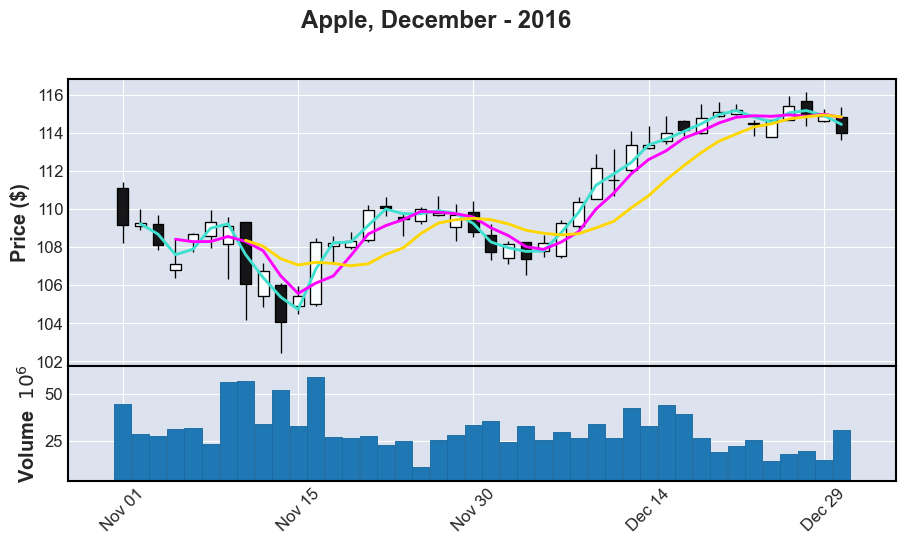

In [18]:
# Moving averages and candles!
# Lets plot for the last month of the data set:

fplt.plot(
    df_apple_last_month,
    type='candle',
    title='Apple, December - 2016',
    ylabel='Price ($)',

    volume = True,
    mav=(2,4,8),
    figratio=(20,10),

)


In [19]:
# Perform ADF on data set:
def adf_print(df):
    adft = adfuller(df['Close'], autolag='AIC') # AIC specifies lag length used in the test.
    adft_output_df = pd.Series(adft[0:4],index=['Test Statistics',
                                                'p-value',
                                                'No. of lags used',
                                                'Number of observations used'])
    for key, val in adft[4].items():
        adft_output_df['critical value (%s)'%key] = val

    print(adft_output_df)
    if adft_output_df['p-value'] > 0.05:
        print('p-value > 0.05 , Failed to reject null hypothesis')
    else:
        print('p-value < 0.05, Reject null hypothesis, times s')

adf_print(df_apple)

Test Statistics                   4.373924
p-value                           1.000000
No. of lags used                 37.000000
Number of observations used    8326.000000
critical value (1%)              -3.431136
critical value (5%)              -2.861887
critical value (10%)             -2.566955
dtype: float64
p-value > 0.05 , Failed to reject null hypothesis


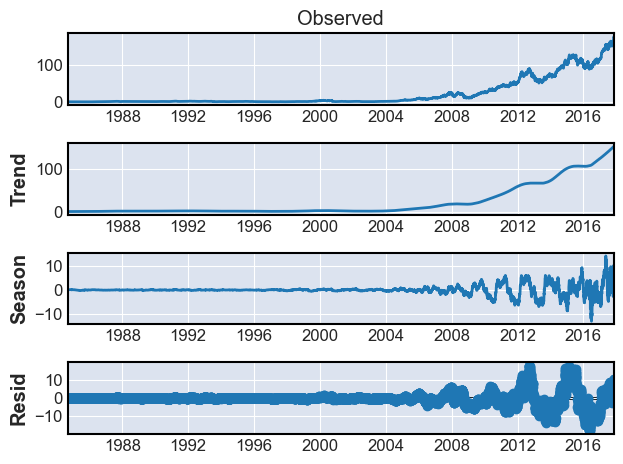

<Figure size 2000x800 with 0 Axes>

In [22]:
result_stl = STL(df_apple[['Close']], period=365).fit()
result_stl.plot()
plt.show()

## Feature Engineering

We will create several engineered features which will be used for our prediction:

1.

In [36]:
# Moving averages:
# By using shift here, you are using the moving averages from the previous day as an input for today! This is important
# as you can not use a moving average that includes today's price to predict today's closing price.

# Exponential moving average with a half life of 10 days. This implies that the observation loses half it value in
# the moving average by the 9th day. For more info: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html
# The second moving average is for 35 days. Therefore it will have a longer history to rely on.
df_apple['EMA_5'] = df_apple['Close'].ewm(halflife=timedelta(days=5), min_periods=5, times=df_apple.index).mean().shift()
df_apple['EMA_10'] = df_apple['Close'].ewm(halflife=timedelta(days=10), min_periods=9, times=df_apple.index).mean().shift()
df_apple['EMA_35'] = df_apple['Close'].ewm(halflife=timedelta(days=35), min_periods=35, times=df_apple.index).mean().shift()


# These are standard moving averages. They do not take into account any history of the closing price beyond what is
# explicitly within the window specified within the rolling() function. The shift is again used to ensure we are not
# taking into account today's average when predicting today's prices. We are looking at yesterday instead.
df_apple['SMA_5'] = df_apple['Close'].rolling(5).mean().shift()
df_apple['SMA_10'] = df_apple['Close'].rolling(10).mean().shift()
df_apple['SMA_15'] = df_apple['Close'].rolling(15).mean().shift()
df_apple['SMA_30'] = df_apple['Close'].rolling(30).mean().shift()

